# Homework

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
import scipy
import scipy.sparse
import scipy.sparse.linalg

1. Load the dataset

In [8]:
dt = pd.read_csv("../data/data.csv")

In [9]:
dt.head

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

In [10]:
dt.shape

(42000, 785)

In [11]:
set(dt.label.unique())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Convert pandas DataFrame to NumPy array

In [12]:
dt = np.array(dt)

2. Split the data in a matrix $X$ with dimensions $d \times N$ and the labels in a column vector $y$. $d = 784$

In [13]:
X = dt[:, 1:]
y = dt[:, 0]

In [14]:
X.shape

(42000, 784)

In [15]:
y.shape

(42000,)

3. Extract all the digits labeled $l$.

In [16]:
l = [0, 6, 9, 4]

mask = [y_i in l for y_i in y] # True il the element in y is equal to l, False otherwise
y = y[mask]
X = X[mask, :]

In [17]:
X.shape

(16529, 784)

4. Split train and test

In [18]:
def train_test_split(X, y, Ntrain):
    # data = np.append(np.array([y]).T, X.T, axis=1)
    data = np.concatenate((y.reshape((-1, 1)), X.T), axis=1)
    np.random.shuffle(data)
    X_train = data[:Ntrain, 1:].T
    X_test = data[Ntrain:, 1:].T
    y_train = data[:Ntrain, 0]
    y_test = data[Ntrain:, 0]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(X.T, y, int(X.shape[0] * 0.8))

In [19]:
X_train.shape

(784, 13223)

In [20]:
X_test.shape

(784, 3306)

In [21]:
def compute_class_centroids(X, y):
    # Order the dataset following y
    labels = np.unique(y)
    labels.sort()
    nl = len(labels)
    X_temp = []
    for l in labels:
        X_temp.append(X[:, y==l])
    
    # Compute the centroids
    c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    return c_k

In [22]:
def convert_centroids_to_dict(labels, Z_c):
    Z_c_dict = {}
    for temp in zip(labels, Z_c.T):
        l, zc = temp
        Z_c_dict[str(l)] = zc
    return Z_c_dict

In [23]:
def PCA(X, y, k):
    c_k = compute_class_centroids(X, y)
    # Center the matrix
    cx = np.array([np.mean(col) for col in X])

    X_c = (X.T - cx).T
    
    U, _, _ = np.linalg.svd(X_c, full_matrices=False) # U_k in R^(d*k)
    U_k = U[:,:k]
    
    Z = U_k.T @ X_c
    Z_c = convert_centroids_to_dict(np.unique(y), U_k.T @ c_k.T)

    return Z, Z_c, U_k.T

In [24]:
def LDA(X, y, k):
    # Order the dataset following y
    labels = np.unique(y)
    labels.sort()
    nl = len(labels)
    X_temp = []
    for l in labels:
        X_temp.append(X[:, y==l])
    
    # Compute the centroids
    c_k = np.array([np.mean(X_temp[i], axis=1) for i in range(nl)])
    c = np.mean(X, axis=1)

    # Center the class matrices
    X_w = X_temp[0] - c_k[0].reshape((-1, 1))
    for i in range(1, nl):
        X_w = np.concatenate((X_w, X_temp[i] - c_k[i].reshape((-1, 1))), axis=1)

    # Compute S_w
    S_w = X_w @ X_w.T

    # Compute S_b
    X_bar = np.repeat(c_k[0].reshape((-1, 1)), X_temp[0].shape[1], axis=1)
    for i in range(1, nl):
        X_bar_i = np.repeat(c_k[i].reshape((-1, 1)), X_temp[i].shape[1], axis=1)
        X_bar = np.concatenate((X_bar, X_bar_i), axis=1)
    X_barc = X_bar - c.reshape((-1, 1))
    S_b = X_barc @ X_barc.T

    try:
        L = np.linalg.cholesky(S_w)
    except LinAlgError:    
        # Create a matrix to correct S_w to make it positive definite
        eps = 1e-6
        I_eps = np.eye(S_w.shape[0]) * eps
        S_w = S_w + I_eps
        # Decomposition
        L = np.linalg.cholesky(S_w)

    # Compute W
    L_inv = np.linalg.inv(L)
    eig_val, W = scipy.sparse.linalg.eigs(L_inv @ S_b @ L, k=k)
    W = np.real(W)

    # Compute Q.T
    Q_t = (L_inv.T @ W).T

    # Compute the projection of our data
    Z = Q_t @ X
    # and the centroid
    Z_c = convert_centroids_to_dict(labels, Q_t @ c_k.T)

    return Z, Q_t, Z_c

In [25]:
def get_intra_cluster_dists(Z, Z_c, y):
    # Compute mean distance of the point in a cluster with the centroid
    intra_dists = {}
    for cluster, coord in Z_c.items():
        cluster_points = Z[:, y==int(cluster)]
        intra_dists[cluster] = np.mean(np.array([np.linalg.norm(x - Z_c[cluster]) for x in cluster_points.T]))
    return intra_dists

In [26]:
Z_LDA, Q_t, Z_LDA_c = LDA(X_train, y_train, 2)
Z_LDA.shape, Z_LDA_c

((2, 13223),
 {'0': array([ 0.03968431, -0.00280877]),
  '4': array([-0.02291059, -0.00795861]),
  '6': array([0.00544445, 0.04140371]),
  '9': array([-0.0236671 , -0.01883451])})

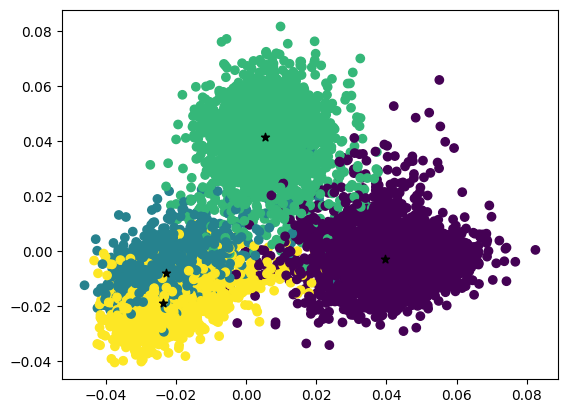

In [27]:
plt.scatter(Z_LDA[0, :], Z_LDA[1, :], c=y_train)
for key, val in Z_LDA_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

In [28]:
print(get_intra_cluster_dists(Z_LDA, Z_LDA_c, y_train))

{'0': 0.012189558554428593, '4': 0.007829057609727979, '6': 0.011675893154887283, '9': 0.008503607907587297}


In [29]:
Z_PCA, Z_PCA_c, U_kt = PCA(X_train, y_train, 2)
Z_PCA.shape, Z_PCA_c

((2, 13223),
 {'0': array([1480.61057532, -299.21228218]),
  '4': array([-27.92744893, -50.74166336]),
  '6': array([ 398.51695663, -669.443444  ]),
  '9': array([-47.99444177, -73.00487319])})

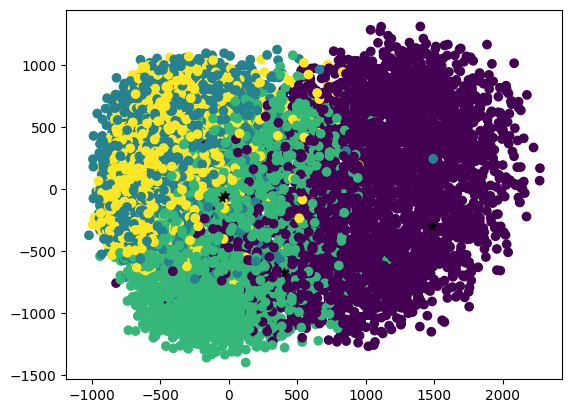

In [30]:
plt.scatter(Z_PCA[0, :], Z_PCA[1, :], c=y_train)
for key, val in Z_PCA_c.items():
    plt.scatter(val[0], val[1], c="black", marker="*", label=key)
plt.show()

In [31]:
print(get_intra_cluster_dists(Z_PCA, Z_PCA_c, y_train))

{'0': 860.4605025950015, '4': 692.1019080474692, '6': 762.0702853464617, '9': 687.8245951942223}


Compute the distance from the centroids on the test set

In [32]:
Z_LDA_test = Q_t @ X_test
get_intra_cluster_dists(Z_LDA_test, Z_LDA_c, y_test)

{'0': 0.013915611395130294,
 '4': 0.008209802876123364,
 '6': 0.012344212114476545,
 '9': 0.009009857911111543}

In [33]:
# Center the matrix
X_test_centered = np.array([np.mean(col) for col in X_test])
X_test_centered = (X_test.T - X_test_centered).T

Z_PCA_test = U_kt @ X_test_centered
get_intra_cluster_dists(Z_PCA_test, Z_PCA_c, y_test)

{'0': 845.381274983601,
 '4': 680.4050088723237,
 '6': 755.861968370591,
 '9': 668.5516233028343}

### Build a classifier using PCA and LDA

In [34]:
def find_nearest_centroid(point, centroid_dict):
    distance_v = []
    labels = []
    for k in centroid_dict.keys():
        distance_v.append(np.linalg.norm(centroid_dict[k] - point))
        labels.append(k)
    
    return int(labels[distance_v.index(min(distance_v))])

In [45]:
def generic_classifier(Z_c, T_matrix, X_test):
    Z = T_matrix @ X_test
    # Find the nearest centroid
    y_predicted = []
    for point in Z.T:
        y_predicted.append(find_nearest_centroid(point, Z_c))
    
    return np.array(y_predicted)

In [46]:
def PCA_classifier(X_train, y_train, X_test, k=2):
    _, Z_PCA_c, U_kt = PCA(X_train, y_train, k=k)
    # Center the matrix
    X_test_centered = np.array([np.mean(col) for col in X_test])
    X_test_centered = (X_test.T - X_test_centered).T    
    return generic_classifier(Z_PCA_c, U_kt, X_test_centered)

In [47]:
def LDA_classifier(X_train, y_train, X_test, k=2):
    _, Q_t, Z_LDA_c = LDA(X_train, y_train, k=k)
    return generic_classifier(Z_LDA_c, Q_t, X_test)

In [48]:
def compute_accuracy(y_true, y_guess):
    return (len(y_true) - np.count_nonzero(y_true - y_guess)) / len(y_true) * 100

In [61]:
for k in range(2, 30, 2):
    y_predicted = PCA_classifier(X_train, y_train, X_test, k=k)
    print("acc with k = "+ str(k) + ": " + str(compute_accuracy(y_test, y_predicted)) + " %")

acc with k = 2: 53.23653962492438 %
acc with k = 4: 69.44948578342408 %
acc with k = 6: 77.58620689655173 %
acc with k = 8: 74.01693889897156 %
acc with k = 10: 74.77313974591652 %
acc with k = 12: 78.94736842105263 %
acc with k = 14: 81.60919540229885 %
acc with k = 16: 81.60919540229885 %
acc with k = 18: 83.54506957047792 %
acc with k = 20: 83.54506957047792 %
acc with k = 22: 83.7265577737447 %
acc with k = 24: 84.08953418027828 %
acc with k = 26: 84.05928614640048 %
acc with k = 28: 84.21052631578947 %


In [63]:
for k in range(1, 5, 1):
    y_predicted = LDA_classifier(X_train, y_train, X_test, k=k)
    print("acc with k = "+ str(k) + ": " + str(compute_accuracy(y_test, y_predicted)) + " %")

acc with k = 1: 71.44585601935874 %
acc with k = 2: 88.0520266182698 %
acc with k = 3: 94.97882637628554 %
acc with k = 4: 94.85783424077435 %


## Visualizing a dyad

In [ ]:
# TODO